In [1]:
import os
import re

import pandas as pd
import textract

### Read in preprints

In [2]:
preprints = os.listdir("preprints/")

In [3]:
from tqdm import tqdm
fails = 0
doc_list = []
good_titles = []  # useful later
for p in tqdm(preprints):
    try:
        doc_list.append(textract.process(f"preprints/{p}").decode())
        good_titles.append(p)
    except:
        fails = fails+1

100%|██████████| 659/659 [02:36<00:00,  4.21it/s]


In [4]:
fails

48

### LDA Model

Notes:
- Almost need token_pattern in CountVectorizer due to numbers like years being fairly common in the documents
- Looks like `tokenizer` argument overrides `token_pattern` argument
- N-grams are generated after tokenizing, so we can get tokenized n-grams
- Issue with using stopwords list with custom tokenizer; tried setting max_df lower to compensate
- Code based on example from here: `https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html`

In [4]:
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

STEMMER = SnowballStemmer("english")

def custom_tokenizer(document):
    tokens = word_tokenize(document)
    tokens = [t for t in tokens if re.match("[a-zA-Z]", t)]
    tokens = [STEMMER.stem(t) for t in tokens]
    return tokens

n_features = 1000
n_components = 10

tf_vectorizer = CountVectorizer(max_df=0.75,
                                min_df=3,
                                max_features=n_features,
                                tokenizer=custom_tokenizer,
                                ngram_range=(1,2))

term_frequencies = tf_vectorizer.fit_transform(doc_list)

In [5]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method='online',
                                random_state=0)
lda_topics = lda.fit_transform(term_frequencies)

In [6]:
import pandas as pd
lda_topic_df = pd.DataFrame(lda_topics.round(2), columns=[f"Topic {x}" for x in range(1,11)], index=good_titles)
lda_topic_df.head(6)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
Patient experiences with group behavioral activation in a partial hospital program.docx,0.00,0.0,0.42,0.00,0.07,0.00,0.00,0.00,0.00,0.51
"Refractory postconcussive symptoms A survey study of concussion knowledge, treatment strategies, and subjective cognitive functioning.docx",0.00,0.0,0.70,0.04,0.11,0.03,0.00,0.11,0.00,0.01
Aerobic exercise enhances positive emotional reactivity in individuals with depressive symptoms Evidence from neural responses to reward and emotional content.pdf,0.00,0.0,0.28,0.58,0.01,0.00,0.00,0.13,0.00,0.00
Variation among Mechanical Turk Workers Across Time of Day Presents an Opportunity and a Challenge for Research.pdf,0.00,0.0,0.00,0.16,0.00,0.31,0.00,0.04,0.03,0.46
The Italian Covid-19 Psychological Research Consortium ( IT C19PRC) General Overview and Replication of the UK study.docx,0.00,0.0,0.00,0.00,0.01,0.05,0.03,0.00,0.91,0.00
Effects of COVID-19-related worry and rumination on mental health and wellbeing during the pandemic Longitudinal analyses of adults in the UK COVID-19 Mental Health & Wellbeing study.pdf,0.14,0.0,0.00,0.00,0.00,0.03,0.00,0.00,0.83,0.00


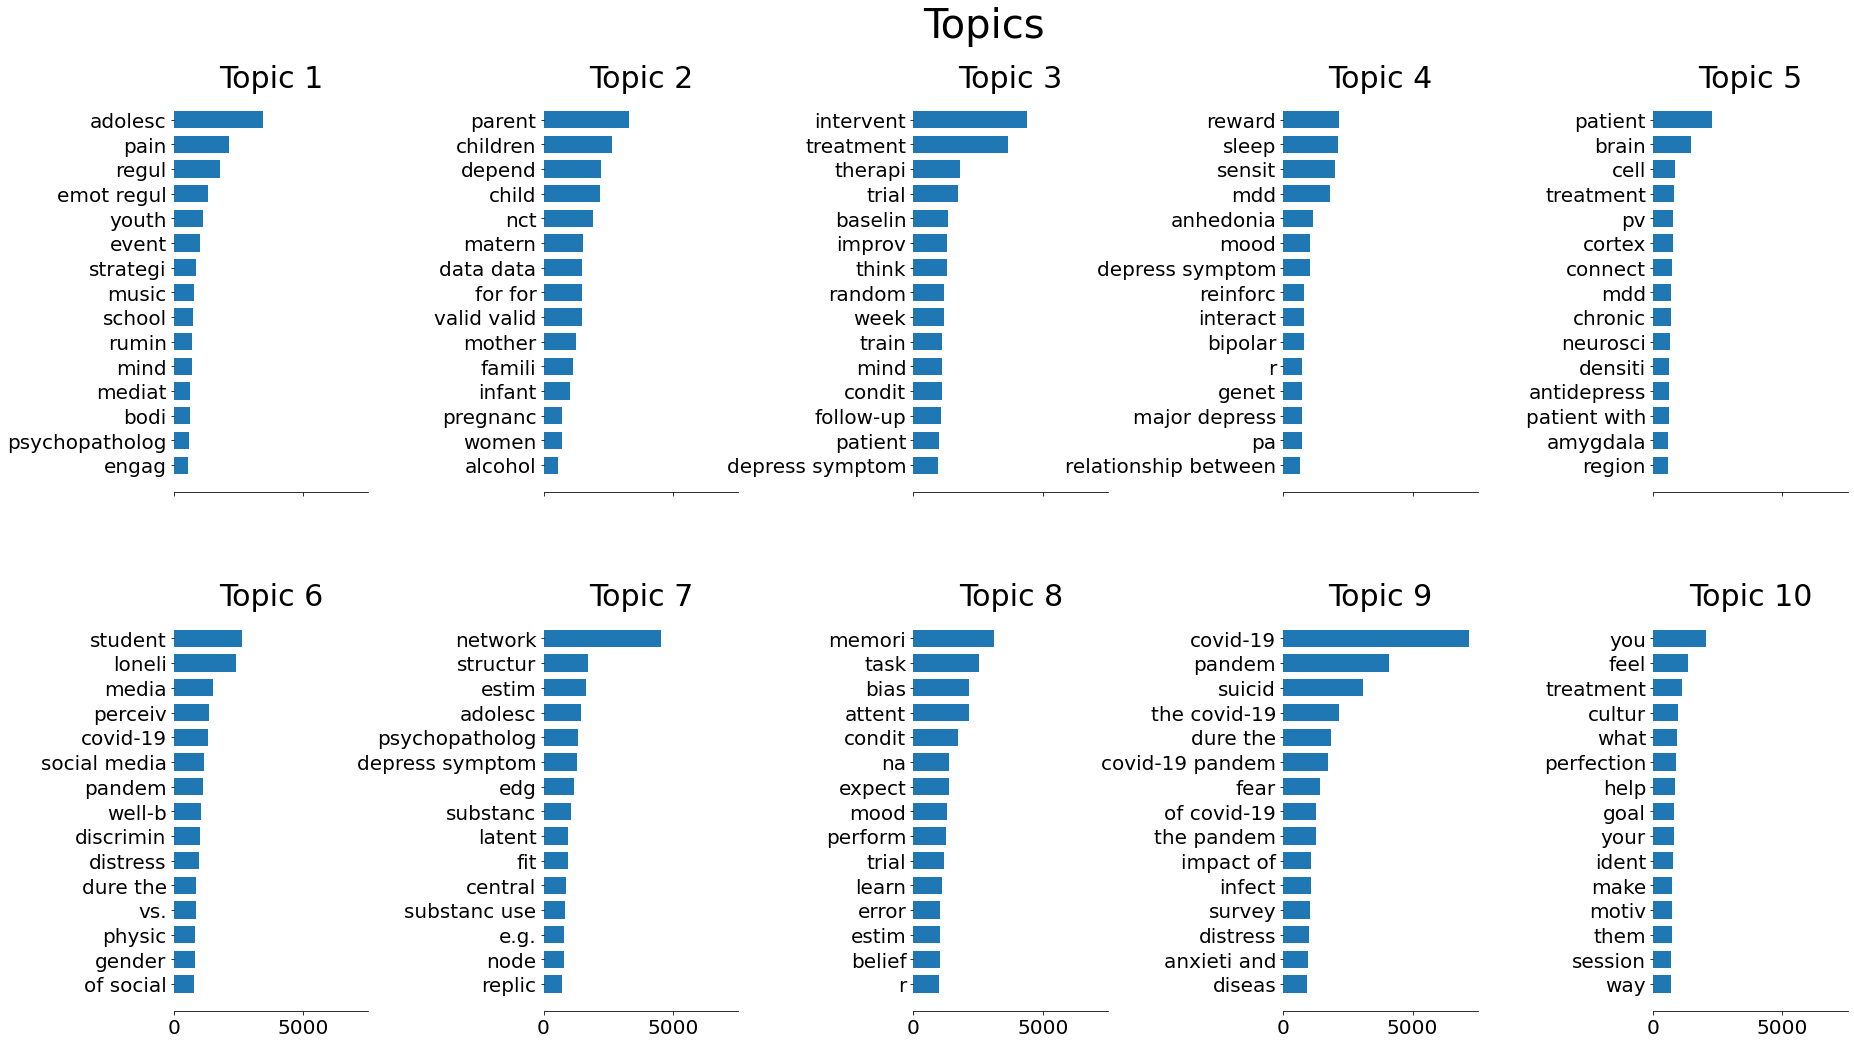

In [7]:
import matplotlib.pyplot as plt

## function copied verbatim from sklearn docs
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, tf_vectorizer.get_feature_names(), 15, "Topics")

In [10]:
lda_topic_df = pd.DataFrame(lda_topics.round(2), columns=[f"Topic {x}" for x in range(1,11)], index=good_titles)

In [16]:
lda_topic_df.sort_values("Topic 10", axis=0, ascending=False).head(20)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
Psilocybin for Depression The ACE Model Manual.pdf,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
Loss and assimilation Lived experiences of Brexit for British citizens living in Luxembourg.pdf,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.94
Existential Intelligence Scale and its Implications for Preliminary Assessment of Existential Neurosis.pdf,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.05,0.92
"The way of making choices maximizing and satisficing and its relationship to well- being, personality, and self-rumination.pdf",0.02,0.00,0.00,0.03,0.00,0.00,0.00,0.06,0.00,0.89
"Precarious Life, Homelessness and the role of counseling psychologists.doc",0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.08,0.86
Domain-specific perfectionism An examination of perfectionism beyond the trait-level and its link to well-being.docx,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.10,0.00,0.85
The Yale Manual for Psilocybin-Assisted Therapy of Depression (using Acceptance and Commitment Therapy as a Therapeutic Frame).pdf,0.01,0.00,0.13,0.00,0.01,0.00,0.00,0.00,0.00,0.85
"Maladaptive Perfectionism, Disguised Distress, and Help Seeking in the Culture of “Saving Face” Links to Anxiety and Depressive Symptoms among Asian Youth.pdf",0.08,0.02,0.00,0.00,0.00,0.03,0.00,0.00,0.02,0.83
Family Matters Rethinking the Psychology of Human Social Motivation.pdf,0.03,0.09,0.00,0.01,0.01,0.03,0.00,0.01,0.00,0.82
McLaughlin et al. (2020) - PRS - Who are the Religious Dones?.pdf,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.12,0.00,0.81


In [36]:
a_doc = textract.process("preprints/Psilocybin for Depression The ACE Model Manual.pdf").decode()

In [37]:
a_doc.count("you")

702

In [42]:
term_frequencies

<611x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 294621 stored elements in Compressed Sparse Row format>

In [47]:
tf_vectorizer.get_feature_names().index("you")

994

In [52]:
term_frequencies[:,994].sum()

2973

In [33]:
lda_topic_df.corr().round(3)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
Topic 1,1.000,-0.011,-0.099,-0.024,-0.047,-0.014,-0.037,-0.102,-0.157,-0.120
Topic 2,-0.011,1.000,-0.071,-0.015,-0.085,-0.074,-0.050,-0.133,-0.015,-0.066
Topic 3,-0.099,-0.071,1.000,-0.119,-0.047,-0.232,-0.183,-0.096,-0.254,-0.104
Topic 4,-0.024,-0.015,-0.119,1.000,0.072,-0.188,-0.052,-0.060,-0.220,-0.199
Topic 5,-0.047,-0.085,-0.047,0.072,1.000,-0.172,-0.082,-0.008,-0.171,-0.096
Topic 6,-0.014,-0.074,-0.232,-0.188,-0.172,1.000,-0.114,-0.196,0.047,-0.077
Topic 7,-0.037,-0.050,-0.183,-0.052,-0.082,-0.114,1.000,-0.156,-0.199,-0.115
Topic 8,-0.102,-0.133,-0.096,-0.060,-0.008,-0.196,-0.156,1.000,-0.244,-0.085
Topic 9,-0.157,-0.015,-0.254,-0.220,-0.171,0.047,-0.199,-0.244,1.000,-0.186
Topic 10,-0.120,-0.066,-0.104,-0.199,-0.096,-0.077,-0.115,-0.085,-0.186,1.000


## Non-Negative Matrix Factorization Analysis

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

tfidf_vectorizer = TfidfVectorizer(max_df=0.75,
                                   min_df=3,
                                   max_features=n_features,
                                   tokenizer=custom_tokenizer,
                                   ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(doc_list)

In [75]:
nmf = NMF(n_components=n_components,
          random_state=1,
          alpha=.05,
          l1_ratio=.5)
nmf_topics = nmf.fit_transform(tfidf)

In [76]:
pd.DataFrame(nmf_topics.round(2))

,0,1,2,3,4,5,6,7,8,9
0,0.09,0.00,0.00,0.0,0.20,0.0,0.0,0.00,0.05,0.00
1,0.10,0.00,0.00,0.0,0.16,0.0,0.0,0.01,0.00,0.12
2,0.10,0.00,0.00,0.0,0.04,0.0,0.0,0.00,0.07,0.00
3,0.14,0.01,0.00,0.0,0.00,0.0,0.0,0.11,0.00,0.00
4,0.04,0.27,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
606,0.20,0.00,0.00,0.0,0.02,0.0,0.0,0.00,0.00,0.00
607,0.24,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.05
608,0.07,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.06,0.17
609,0.02,0.00,0.02,0.0,0.00,0.0,0.0,0.00,0.42,0.00


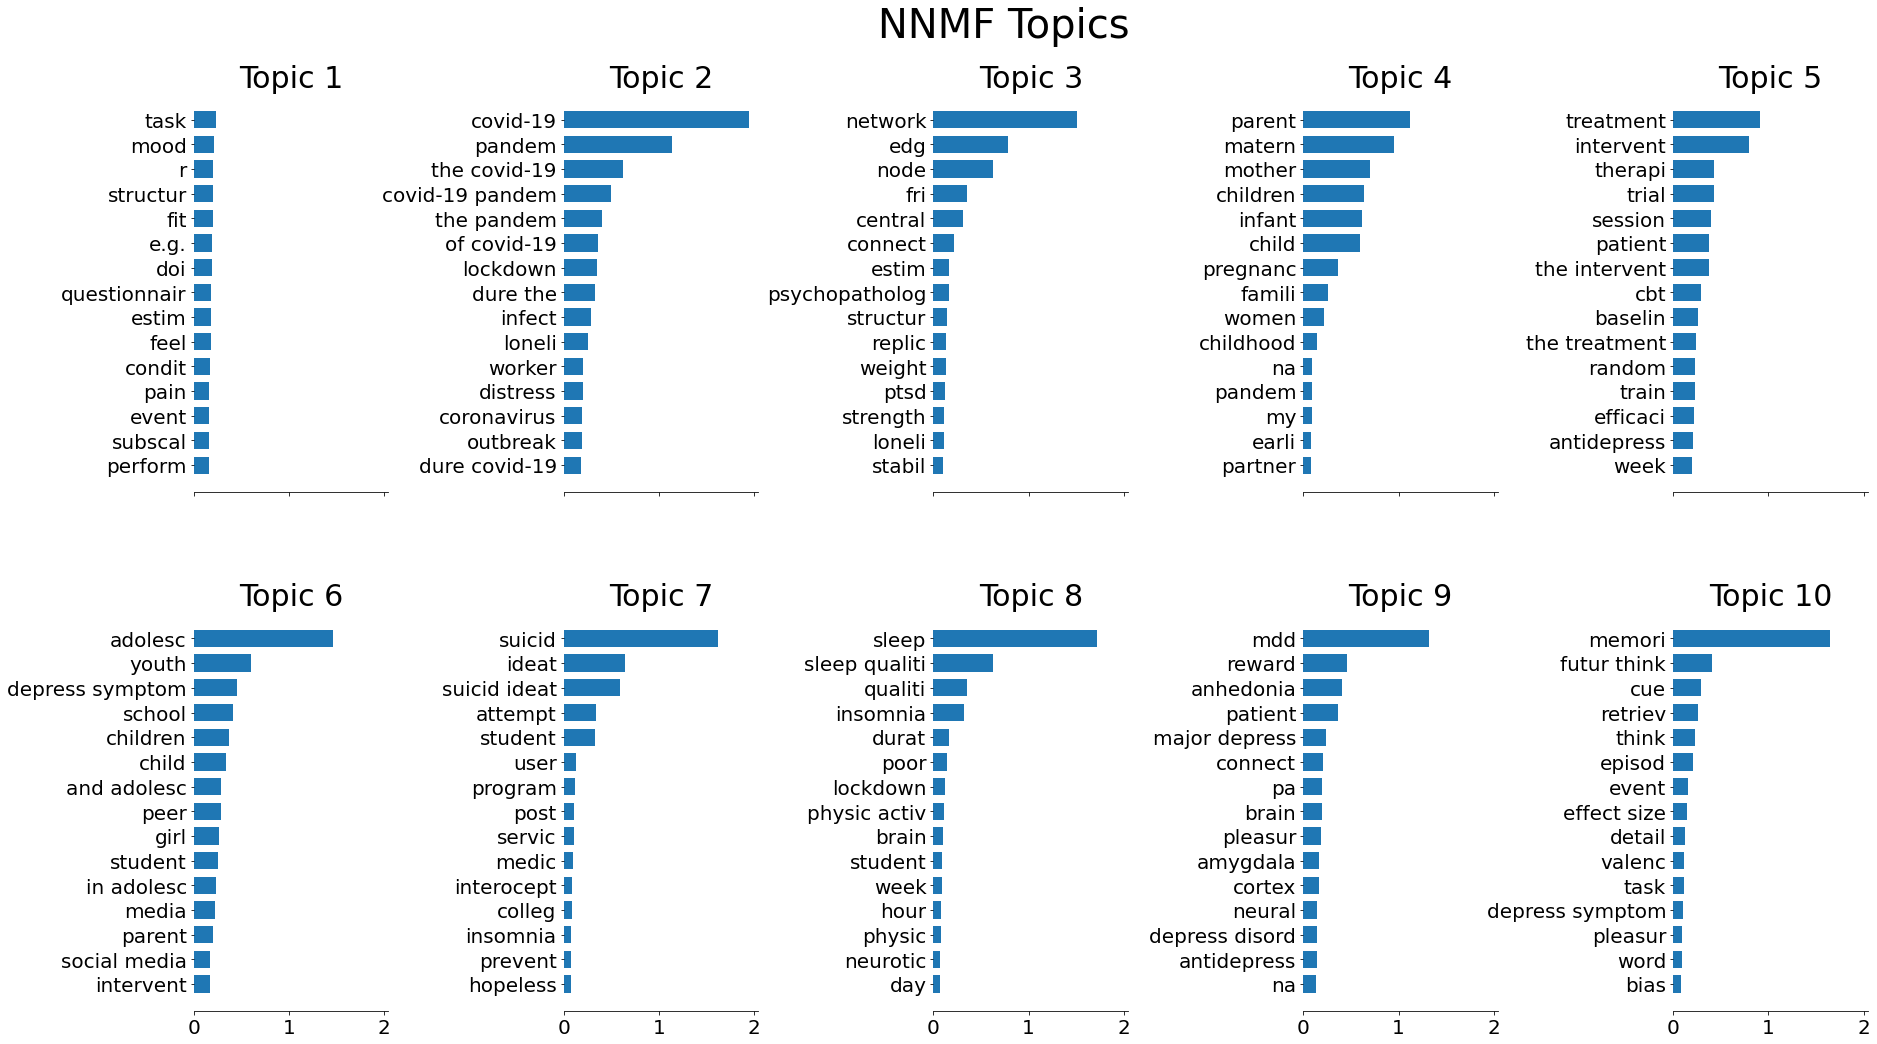

In [77]:
plot_top_words(nmf, tfidf_vectorizer.get_feature_names(), 15, 'NNMF Topics')

### Other stuff

In [14]:
import pandas as pd
psyarxiv = pd.read_csv("psyarxiv.csv", converters={"Disciplines":eval})

In [19]:
# number of disciplines in the records
discipline_list=[x for y in psyarxiv["Disciplines"].tolist() for x in y]